# 4.5 - Transfer learning

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

replicating local resources


In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
%matplotlib inline
%load_ext tensorboard

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: [https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/)

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [3]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1.4M -rw-r--r-- 1 root root 1.4M Sep  3 22:51 local/data/alexnet_conv1_conv2.pklz


In [4]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
for k,(w,b) in alex_c12.items():
    print(k, b.shape, w.shape)

b'conv2' (256,) (5, 5, 48, 256)
b'conv1' (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


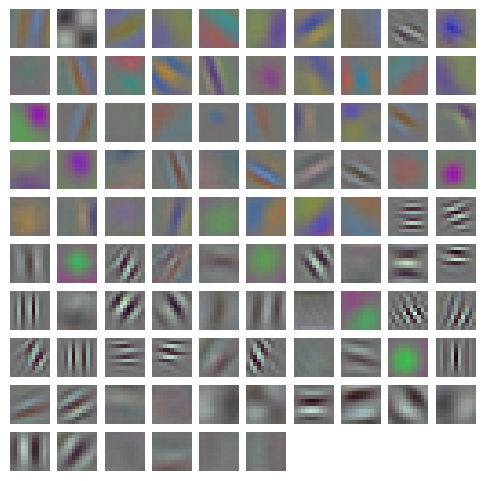

In [5]:
alex_w1 = alex_c12[b"conv1"][0]
print(alex_w1.shape)
mlutils.display_imgs(alex_w1)

### We will use them as starting point for training our network

In [6]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

--2025-09-03 22:51:35--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.117.16, 3.5.12.130, 3.5.8.74, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.117.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5’

mini_cifar.h5       100%[===================>]  14.12M  18.9MB/s    in 0.7s    

2025-09-03 22:51:36 (18.9 MB/s) - ‘mini_cifar.h5’ saved [14803609/14803609]



In [7]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

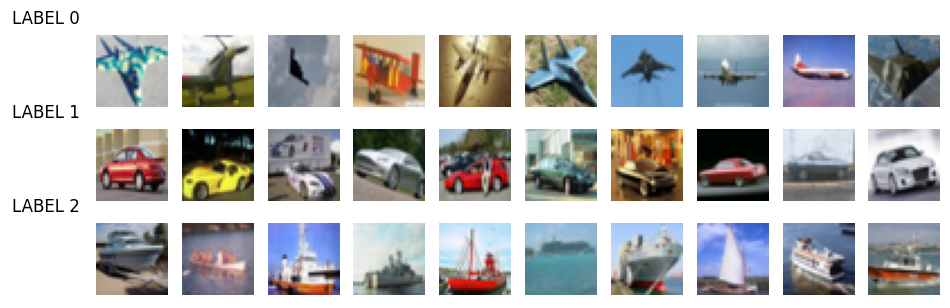

In [8]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    773
0    745
1    735
Name: count, dtype: int64

distribution of test classes
0    260
2    252
1    239
Name: count, dtype: int64


In [10]:
def get_model(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [14]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [15]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)
model.summary()

using 3 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 60)       │       697,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_1 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 732,991 (2.80 MB)

 Trainable params: 732,991 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

## Train from scratch

in some runs might take a while to start reducing loss

In [16]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.3740 - loss: 1.1126 - val_accuracy: 0.5193 - val_loss: 0.9987
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.4912 - loss: 1.0197 - val_accuracy: 0.5300 - val_loss: 0.9636
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5245 - loss: 0.9775 - val_accuracy: 0.5606 - val_loss: 0.9048
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5524 - loss: 0.9097 - val_accuracy: 0.5979 - val_loss: 0.8650
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5700 - loss: 0.9040 - val_accuracy: 0.5992 - val_loss: 0.8447
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6119 - loss: 0.8549 - val_accuracy: 0.6232 - val_loss: 0.8197
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5971 - loss: 0.8328 - val_accuracy: 0.6099 - val_loss: 0.8470
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6235 - loss: 0.8068 - val

{'loss': 0.8849406838417053, 'compile_metrics': 0.6231691241264343}

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Normalized confusion matrix
[[0.55769231 0.2        0.24230769]
 [0.0292887  0.92050209 0.05020921]
 [0.26190476 0.32936508 0.40873016]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

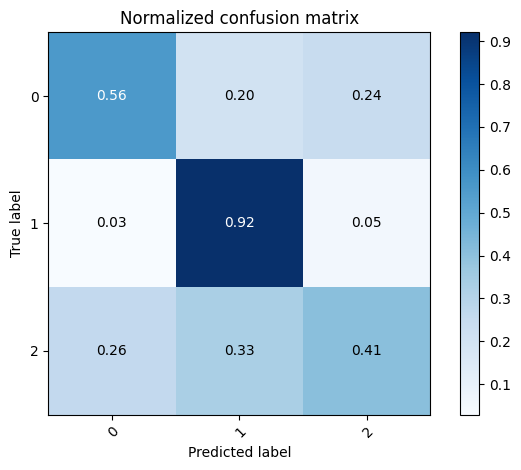

In [17]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

## Transfer learning!!!

- Keep first level filters to compare later


In [18]:
model = get_model(num_classes)
w = model.get_weights()
for i in w:
    print(i.shape)

using 3 classes
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


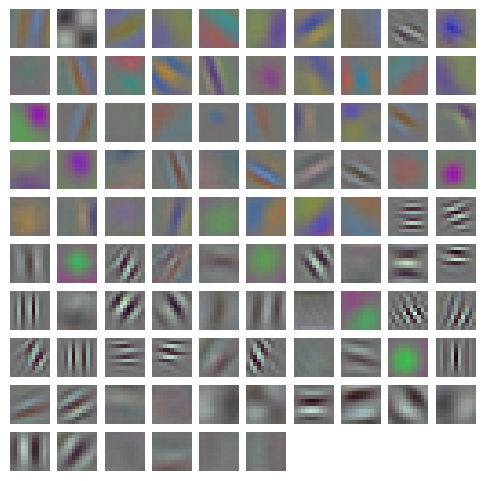

In [19]:
w[0] = alex_w1
model.set_weights(w)
mlutils.display_imgs(model.get_weights()[0])

In [20]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.4418 - loss: 1.1226 - val_accuracy: 0.6085 - val_loss: 0.9157
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5626 - loss: 0.9337 - val_accuracy: 0.6378 - val_loss: 0.7739
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.6051 - loss: 0.8411 - val_accuracy: 0.6405 - val_loss: 0.7577
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6368 - loss: 0.8208 - val_accuracy: 0.6858 - val_loss: 0.7430
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6822 - loss: 0.7065 - val_accuracy: 0.7044 - val_loss: 0.7052
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7372 - loss: 0.6665 - val_accuracy: 0.7230 - val_loss: 0.6823
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7453 - loss: 0.6464 - val_accuracy: 0.7230 - val_loss: 0.6871
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7457 - loss: 0.6077 - va

{'loss': 0.7401493787765503, 'compile_metrics': 0.7296937704086304}

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Normalized confusion matrix
[[0.63076923 0.06153846 0.30769231]
 [0.06694561 0.74476987 0.18828452]
 [0.09920635 0.08333333 0.81746032]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

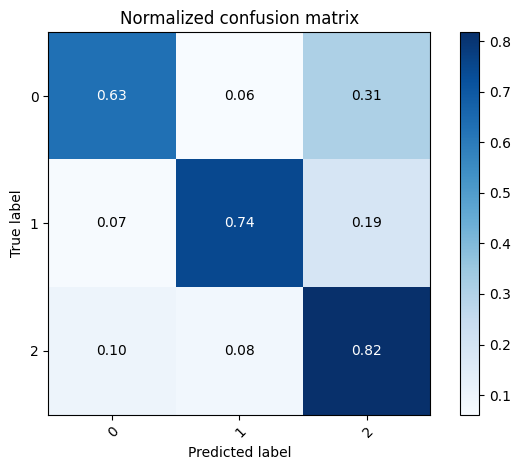

In [21]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

first level filters changed but not much

In [22]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

np.float32(0.02194051)

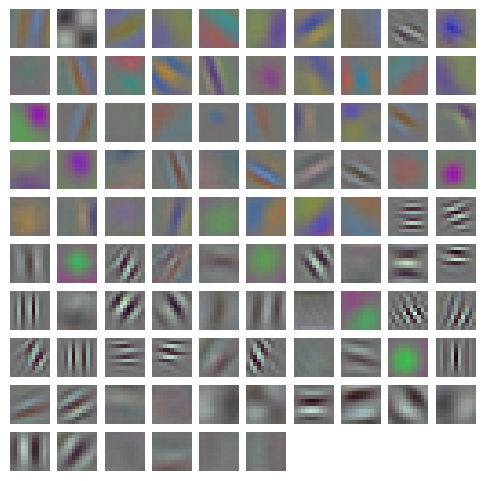

In [23]:
mlutils.display_imgs(w[0])

In [28]:
model.save("alexnet_finetuned_minicifar.keras")

observe that you can also save separately the architecture

In [29]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [30]:
!ls -lash alexnet_finetuned_minicifar*

8.0K -rw-r--r-- 1 root root 7.2K Sep  3 22:59 alexnet_finetuned_minicifar.architecture.json
8.5M -rw-r--r-- 1 root root 8.5M Sep  3 22:59 alexnet_finetuned_minicifar.keras


In [31]:
!head alexnet_finetuned_minicifar.architecture.json

{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional_2", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_4", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "filters": 96, "kernel_size": [11, 11], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "confi

## Could also freeze weights to avoid being changed by training

In [32]:
def get_modelT(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu", trainable=False)(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [33]:
model = get_modelT(num_classes)
w = model.get_weights()
w[0] = alex_w1
model.set_weights(w)

using 3 classes


In [34]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4030 - loss: 1.2848 - val_accuracy: 0.5686 - val_loss: 0.8850
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5342 - loss: 0.9216 - val_accuracy: 0.6192 - val_loss: 0.8577
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5781 - loss: 0.9034 - val_accuracy: 0.7017 - val_loss: 0.7563
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6045 - loss: 0.8554 - val_accuracy: 0.7084 - val_loss: 0.7891
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6349 - loss: 0.8040 - val_accuracy: 0.7443 - val_loss: 0.6905
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6771 - loss: 0.7610 - val_accuracy: 0.7563 - val_loss: 0.6842
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6954 - loss: 0.7413 - val_accuracy: 0.7523 - val_loss: 0.6848
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6853 - loss: 0.7366 - val_accu

{'loss': 0.6523975729942322, 'compile_metrics': 0.7842876315116882}

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Normalized confusion matrix
[[0.77307692 0.04230769 0.18461538]
 [0.10041841 0.76987448 0.12970711]
 [0.12698413 0.06349206 0.80952381]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

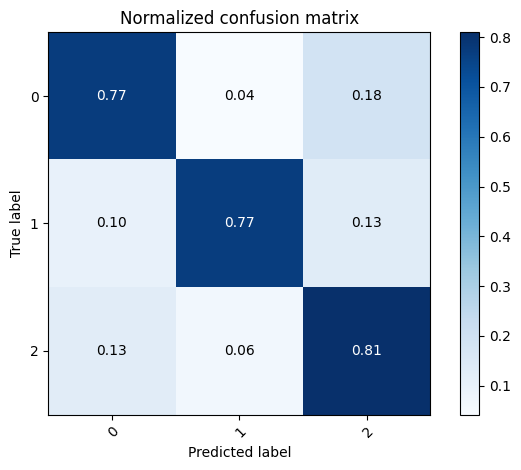

In [35]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

check filters did not change

In [36]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

np.float32(0.0)